<a href="https://colab.research.google.com/github/rosiekwon/smart_healthcare/blob/main/WEEK2%20/%20Medical_image_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Pre-Processing

In [ ]:
!git clone https://github.com/FlashChoi5657/Deepnoid-Education.git

Cloning into 'Deepnoid-Education'...
remote: Enumerating objects: 556, done.
remote: Counting objects: 100% (223/223), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 556 (delta 42), reused 175 (delta 8), pack-reused 333
Receiving objects: 100% (556/556), 156.41 MiB | 20.65 MiB/s, done.
Resolving deltas: 100% (109/109), done.


# 1. Library Import
* 파이썬 라이브러리를 불러오자

In [ ]:
!pip install simpleitk --quiet

     |████████████████████████████████| 52.8 MB 258 kB/s 


In [ ]:
import numpy as np 
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
from sklearn import metrics as skmet
from skimage import morphology
from skimage import measure
from skimage import exposure
from skimage.transform import rotate
import cv2 as cv
from keras.preprocessing import image as kimg

# 2. Data Loading
* 전처리 실습에 사용할 'test.dcm' 파일을 불러오자. 
* 이때 'test.dcm' 파일을 업로드해두지 않았다면 실행 시 에러가 발생할 것이므로 반드시 'test.dcm'을 올리고 실행 시켜야 한다.

# Header Information #
Image Size =  (512, 512, 1)
Pixel Spacing =  (0.646484375, 0.646484375, 1.0)
Image Dimension =  3
Number of Pixel Components =  1
Minimum & Maximum pixel value(Min/Max) = -1000/1844
Image mean & std = -555.9083557128906, 518.929847210932


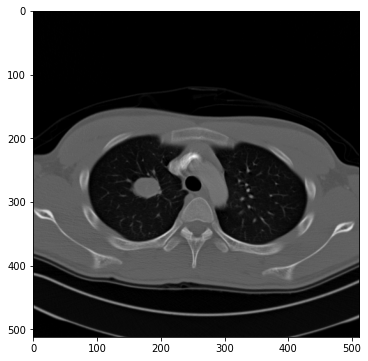

In [ ]:
test_data = './Deepnoid-Education/dataset/test.dcm'
image = sitk.ReadImage(test_data) # simpleitk Object # 2d image load, nifti, NOT 3d image
img_arr = sitk.GetArrayFromImage(image)
print('# Header Information #')
print('Image Size = ', image.GetSize())
print('Pixel Spacing = ', image.GetSpacing())
print('Image Dimension = ', image.GetDimension())
print('Number of Pixel Components = ', image.GetNumberOfComponentsPerPixel())
print('Minimum & Maximum pixel value(Min/Max) = {}/{}'.format(np.min(img_arr), np.max(img_arr)))
print('Image mean & std = {}, {}'.format(np.mean(img_arr), np.std(img_arr)))

plt.figure(figsize=(6,6))
plt.imshow(img_arr[0], cmap='gray')

# 3. Basic Pre-Processing
* 가장 기본적인 전처리들을 알아보자

## 3.1 Resize
* 이미지의 크기를 변화 시키는 모듈

Original Image Size =  (512, 512, 1)
Processed Image Size =  (256, 256, 1)
Original Pixel Spacing =  (0.646484375, 0.646484375, 1.0)
Processed Pixel Spacing =  (1.29296875, 1.29296875, 1.0)


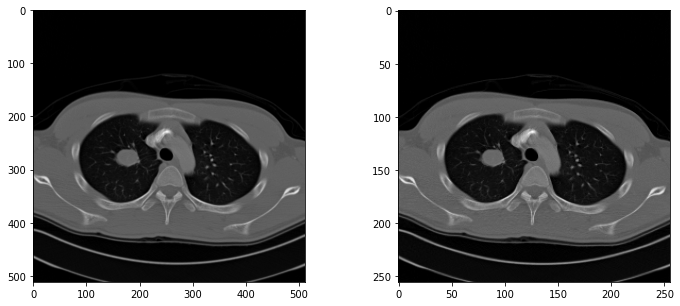

In [ ]:
# Resize
def resize_array(sitk_image, size,interpolator=sitk.sitkLinear):
    original_spacing = sitk_image.GetSpacing()
    original_size = sitk_image.GetSize()
    new_size = list(original_size)
    new_size[0]=size[0]
    new_size[1]=size[1]
    new_spacing = [(ospc * osz / nsz) for osz, ospc, nsz in
                   zip(original_size, original_spacing, new_size)]
    sitk_image = sitk.Resample(sitk_image, new_size, sitk.Transform(), interpolator, 
                               sitk_image.GetOrigin(), new_spacing,
                         sitk_image.GetDirection(), 0, sitk_image.GetPixelID())
    return sitk_image

resize_img = resize_array(image, [256, 256])
print('Original Image Size = ', image.GetSize())
print('Processed Image Size = ', resize_img.GetSize())
print('Original Pixel Spacing = ', image.GetSpacing())
print('Processed Pixel Spacing = ', resize_img.GetSpacing())

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img_arr[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(resize_img)[0], cmap='gray') # (1,512,512) img_arr[0,...]

## 3.2 Resample
* 이미지의 픽셀 간 물리적 거리를 변화시키는 모듈

Original Pixel Spacing =  (0.646484375, 0.646484375, 1.0)
Processed Pixel Spacing =  (1.0, 1.0, 1.0)
Original Image Size =  (512, 512, 1)
Processed Image Size =  (331, 331, 1)


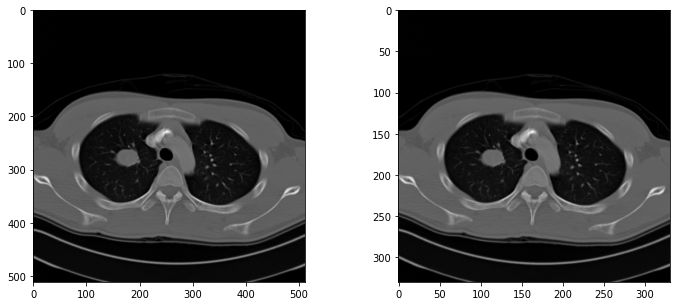

In [ ]:
# Resample
def resample_array(sitk_image, spacing, interpolator=sitk.sitkLinear):
    original_spacing = sitk_image.GetSpacing()
    original_size = sitk_image.GetSize()
    new_spacing = [spacing, spacing, original_spacing[2]]
    new_size = [int(round(osz * ospc / nspc)) for osz, ospc, nspc in
                zip(original_size, original_spacing, new_spacing)]
    sitk_image = sitk.Resample(sitk_image, new_size, sitk.Transform(), interpolator, 
                               sitk_image.GetOrigin(), new_spacing,
                         sitk_image.GetDirection(), 0, sitk_image.GetPixelID())
    return sitk_image

resample_img = resample_array(image, 1)
print('Original Pixel Spacing = ', image.GetSpacing())
print('Processed Pixel Spacing = ', resample_img.GetSpacing())
print('Original Image Size = ', image.GetSize())
print('Processed Image Size = ', resample_img.GetSize())

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img_arr[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(resample_img)[0], cmap='gray')

## 3.3 Min-Max Normalization
* 이미지의 픽셀 값들을 0과 1사이의 값으로 바꾸어 정규화시키는 모듈

Oringinal Image min/max value = -1000/1844
Processed Image min/max value = 0.0/1.0

Sample Patch Comparison(Origin vs Processed)
[[144 141 114 109  94]
 [201 171 152 139 110]
 [396 309 242 179 153]
 [508 519 439 353 328]
 [375 430 452 463 476]]
[[0.40225035 0.4011955  0.39170183 0.38994374 0.38466948]
 [0.42229255 0.41174402 0.40506329 0.40049226 0.39029536]
 [0.49085795 0.46026723 0.43670886 0.41455696 0.40541491]
 [0.5302391  0.53410689 0.5059775  0.4757384  0.46694796]
 [0.48347398 0.50281294 0.51054852 0.51441632 0.51898734]]


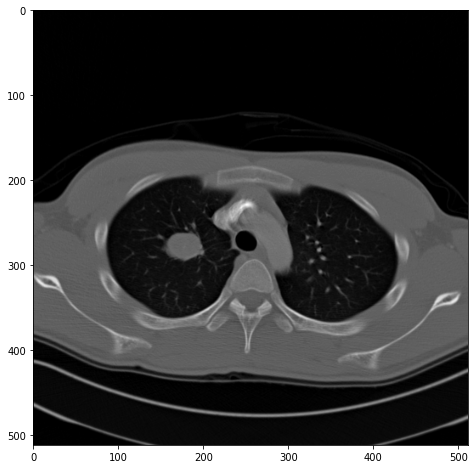

In [ ]:
# MinMax Normalization
norm_img = (img_arr - np.min(img_arr)) / (np.max(img_arr) - np.min(img_arr))
print('Oringinal Image min/max value = {}/{}'.format(np.min(img_arr), np.max(img_arr)))
print('Processed Image min/max value = {}/{}'.format(np.min(norm_img), np.max(norm_img)))
print('\nSample Patch Comparison(Origin vs Processed)')
print(img_arr[0, 185:190, 275:280]) # z,y, x 
print(norm_img[0, 185:190, 275:280])

plt.figure(figsize=(8,8))
plt.imshow(norm_img[0], cmap='gray')

## 3.4 Z-Score Normalization
* Z-score를 이용하여 이미지의 픽셀 값들을 정규화시키는 모듈

Oringinal Image min/max value = -1000/1844
Processed Image min/max value = -0.8557835836075877/4.62472599834364
Oringinal Image mean/std value = -555.9083557128906/518.929847210932
Processed Image mean/std value = -1.1102230246251565e-16/0.9999999999999999

Sample Patch Comparison(Origin vs Processed)
[[144 141 114 109  94]
 [201 171 152 139 110]
 [396 309 242 179 153]
 [508 519 439 353 328]
 [375 430 452 463 476]]
[[1.34875332 1.34297219 1.29094204 1.28130683 1.25240119]
 [1.45859476 1.40078348 1.36416966 1.33911811 1.28323387]
 [1.8343681  1.66671538 1.53760351 1.41619982 1.36609671]
 [2.05019688 2.07139435 1.91723093 1.75150526 1.70332919]
 [1.7939002  1.89988755 1.94228249 1.96347996 1.98853152]]


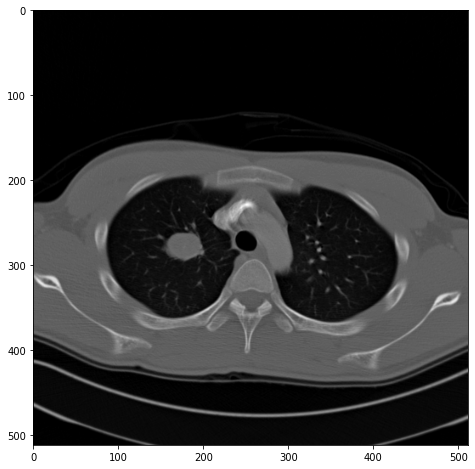

In [ ]:
# Z-Score Normalization
zsc_img = (img_arr - np.mean(img_arr)) / np.std(img_arr)
print('Oringinal Image min/max value = {}/{}'.format(np.min(img_arr), np.max(img_arr)))
print('Processed Image min/max value = {}/{}'.format(np.min(zsc_img), np.max(zsc_img)))
print('Oringinal Image mean/std value = {}/{}'.format(np.mean(img_arr), np.std(img_arr)))
print('Processed Image mean/std value = {}/{}'.format(np.mean(zsc_img), np.std(zsc_img)))
print('\nSample Patch Comparison(Origin vs Processed)')
print(img_arr[0, 185:190, 275:280])
print(zsc_img[0, 185:190, 275:280])

plt.figure(figsize=(8,8))
plt.imshow(zsc_img[0], cmap='gray')

## 3.5 Gamma Correction
* 이미지의 감마 값을 조정하는 모듈

Oringinal Image mean/min/max value = 39.81834363333788/46.528520055832516
Processed Image mean/min/max value = 3750.4036682885867/5472.266011440084


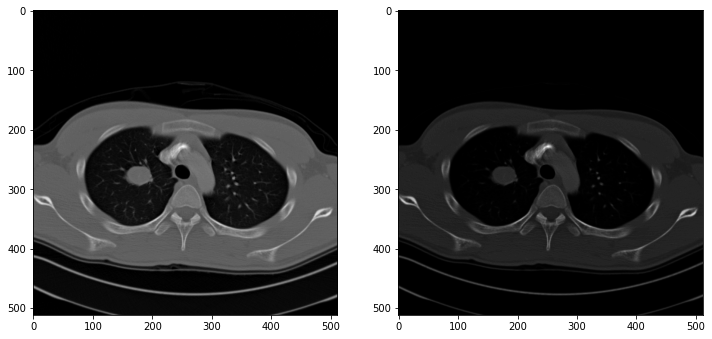

In [ ]:
# Gamma Correction
gamma_cor = exposure.adjust_gamma(255*norm_img, 2.0)
print('Oringinal Image mean/min/max value = {}/{}'.format(np.mean(255*norm_img), np.std(255*norm_img)))
print('Processed Image mean/min/max value = {}/{}'.format(np.mean(gamma_cor), np.std(gamma_cor)))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_arr[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(gamma_cor[0], cmap='gray')

## 3.6 Adaptive Equalization
* 히스토그램 평활화를 수행하는 모듈

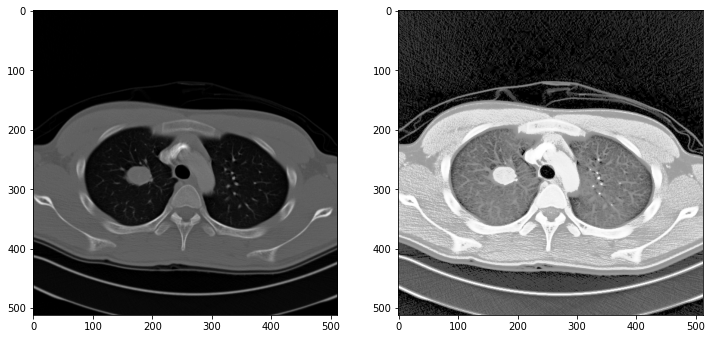

In [ ]:
# Adaptive Equalization
img_eqh = exposure.equalize_hist(img_arr)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_arr[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_eqh[0], cmap='gray')

# 3. Hounsfield Unit Lung Area Segmentation 
* 다양한 영상처리 기법들을 조합하여 폐 CT 영상에서 뼈와 다른 장기들을 제외하고 오직 페영역만 분할해보자.

## 3.1 Hu Conversion
* Hounsfield 값으로 이미지의 픽셀 값들을 변환하자.

In [ ]:
itc = image.GetMetaData('0028|1052') 
slp = image.GetMetaData('0028|1053')
print('Rescale Slope (0028|1053) = ', image.GetMetaData('0028|1053'))
print('Rescale Intercept (0028|1052) = ', image.GetMetaData('0028|1052'))

Rescale Slope (0028|1053) =  1.
Rescale Intercept (0028|1052) =  -1000.


(1, 512, 512) (1, 512, 512)
original =  -1000 1844
HU conversion =  -2000.0 844.0


Text(0.5, 1.0, 'HU Conversion')

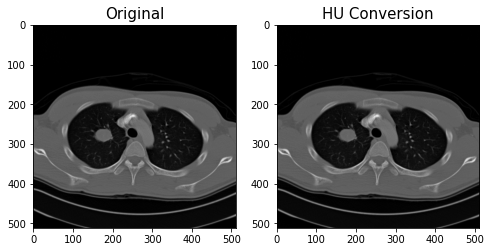

In [ ]:
img_arr_hu = (img_arr * float(slp)) + float(itc)
print(img_arr.shape, img_arr_hu.shape)
print('original = ', np.min(img_arr), np.max(img_arr))
print('HU conversion = ', np.min(img_arr_hu), np.max(img_arr_hu))
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(img_arr[0], cmap='gray')
plt.title('Original', fontsize=15)
plt.subplot(1,2,2)
plt.imshow(img_arr_hu[0], cmap='gray')
plt.title('HU Conversion', fontsize=15)

## 3.2 Window Setting
* 변화된 Hounsfield 값들을 기준으로 뼈와 같이 지나치게 밝은 부분과 공기와 지방과 같이 지나치게 어두운 부분들은 제외시키는 모듈

* https://radiopaedia.org/articles/windowing-ct

Text(0.5, 1.0, 'Mediastinum Setting')

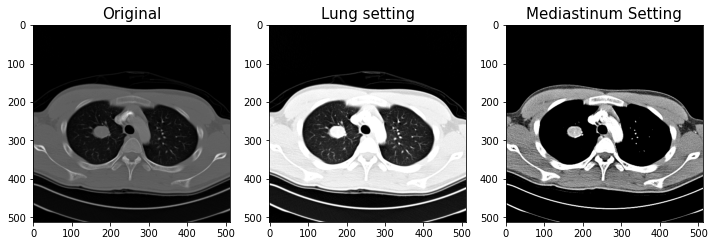

In [ ]:
# img_arr_win1 = np.where(img_arr_hu < -2000, -2000, img_arr_hu)
# img_arr_win = np.where(img_arr_win1 > 150, 150, img_arr_win1) # window setting -2000 ~ +150

def window_setting(array, width, level):
  # img_array = data['image']['array']
  upper = level+ width/2
  lower = level- width/2
  new_array = np.copy(array)
  new_array[new_array<lower] = lower
  new_array[new_array>upper] = upper
  new_array = new_array-lower
  new_array = (new_array/(upper-lower)*255).round().astype(np.uint16)
  return new_array

plt.figure(figsize=(12,24))
plt.subplot(1,3,1)
plt.imshow(img_arr[0], cmap='gray')
plt.title('Original', fontsize=15)
plt.subplot(1,3,2)
plt.imshow(window_setting(img_arr[0], 1500, -600), cmap='gray')
plt.title('Lung setting', fontsize=15)
plt.subplot(1,3,3)
plt.imshow(window_setting(img_arr[0], 350, 50), cmap='gray')
plt.title('Mediastinum Setting', fontsize=15)

## 3.3 Make Mask
* Thresholding된 이미지를 기준으로 폐영역만 나타내는 마스크를 만드는 모듈

0 1


Text(0.5, 1.0, 'Threshold')

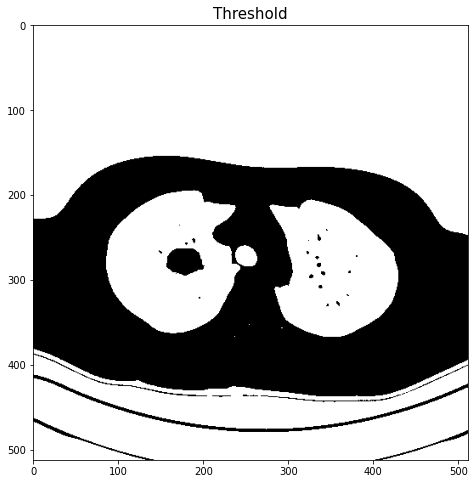

In [ ]:
# Thresholding
img_arr_thres = np.where(img_arr_hu < -1200, 1, 0)
print(np.min(img_arr_thres),np.max(img_arr_thres))

plt.figure(figsize=(8,8))
plt.imshow(img_arr_thres[0], cmap='gray')
plt.title('Threshold', fontsize=15)

Text(0.5, 1.0, 'Eroded')

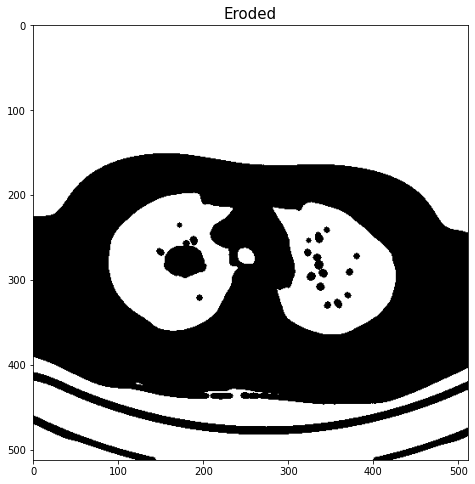

In [ ]:
# Erosion
eroded = morphology.erosion(img_arr_thres[0], morphology.disk(3))

plt.figure(figsize=(8,8))
plt.imshow(eroded, cmap='gray')
plt.title('Eroded', fontsize=15)

Text(0.5, 1.0, 'Dilation')

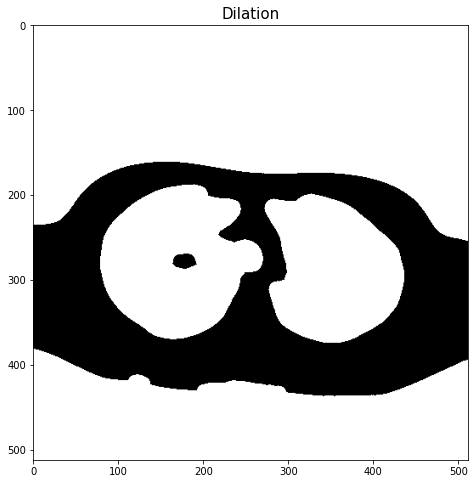

In [ ]:
# Dilation
dilation = morphology.dilation(eroded,morphology.disk(10))

plt.figure(figsize=(8,8))
plt.imshow(dilation, cmap='gray')
plt.title('Dilation', fontsize=15)

Text(0.5, 1.0, 'closing')

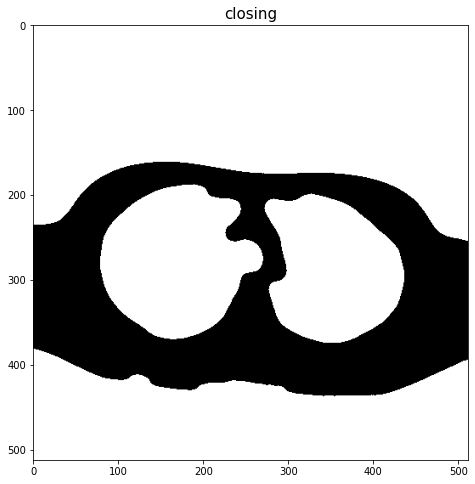

In [ ]:
# Closing
closing = morphology.closing(dilation, morphology.disk(10))

plt.figure(figsize=(8,8))
plt.imshow(closing, cmap='gray')
plt.title('closing', fontsize=15)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]] (512, 512) (array([0, 1, 2, 3, 4]), array([73166, 96064, 24369, 21147, 47398]))


Text(0.5, 1.0, 'Color Labels')

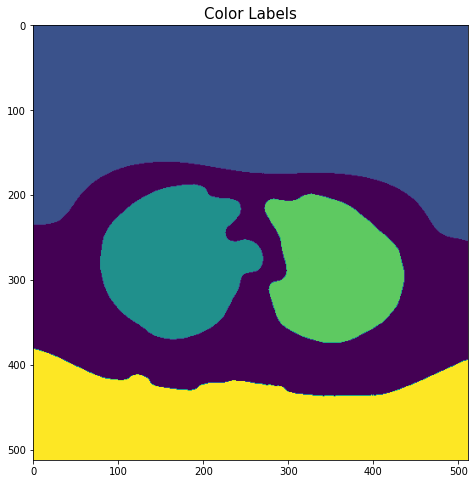

In [ ]:
# color label
labels = measure.label(closing)
print(labels, labels.shape, np.unique(labels, return_counts=True))
show_lab = np.where(labels==0, 1, 0)

plt.figure(figsize=(8,8))
plt.imshow(labels, cmap='viridis')
plt.title('Color Labels', fontsize=15)

4
0 1


Text(0.5, 1.0, 'Final Mask')

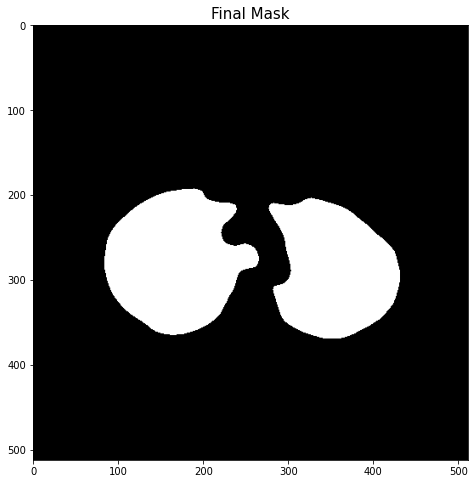

In [ ]:
# find good label
print(np.max(labels))
row_size= labels.shape[0]
col_size = labels.shape[1]
regions = measure.regionprops(labels)
good_labels = []
for prop in regions:
    B = prop.bbox
    if B[2]-B[0]<row_size*0.9 and B[3]-B[1]<col_size*0.9 and B[0]>row_size*0.1 and B[2]>col_size*0.1:
        good_labels.append(prop.label)
mask = np.zeros(shape=(row_size,col_size),dtype=np.int8)
for N in good_labels:
    mask = mask + np.where(labels==N,1,0)
mask = morphology.dilation(mask, morphology.disk(5)) #mask = np.where(labels == 0, 1, 0)
mask = morphology.closing(mask, morphology.disk(5))
mask = morphology.erosion(mask, morphology.disk(10))

print(np.min(mask), np.max(mask))
plt.figure(figsize=(8,8))
plt.imshow(mask, cmap='gray')
plt.title('Final Mask', fontsize=15)

## 3.4 Lung Area Segmentation
* 만들어진 폐영역 분할 마스크를 가지고 페 CT 영상에서 폐영역만 정확하게 분할하는 모듈

Text(0.5, 1.0, 'Final Lung Image')

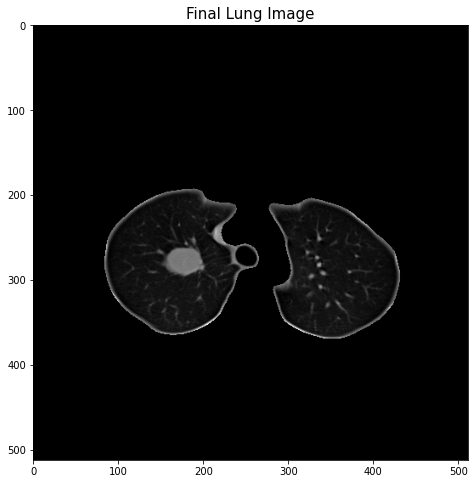

In [ ]:
# final image
img_arr_norm = img_arr_hu+2000
lung_img = img_arr_norm[0] * mask

plt.figure(figsize=(8,8))
plt.imshow(lung_img, cmap='gray')
plt.title('Final Lung Image', fontsize=15)

Text(0.5, 1.0, 'CLAHE Lung Image')

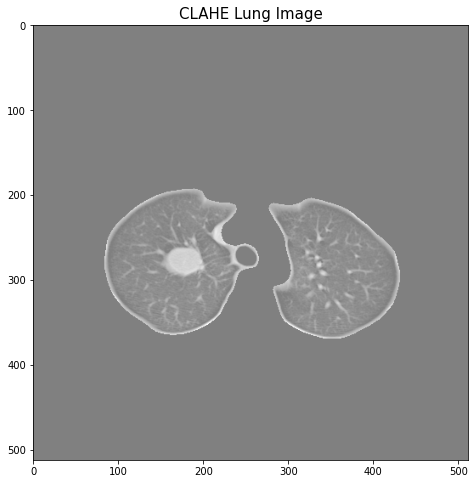

In [ ]:
# Adaptive Equalization
rescale_image = (lung_img - np.mean(lung_img)) / (np.max(lung_img) - np.mean(lung_img))
aeh_img = exposure.equalize_adapthist(rescale_image, clip_limit=0.01)

plt.figure(figsize=(8,8))
plt.imshow(aeh_img, cmap='gray', vmin=-1, vmax=1)
plt.title('CLAHE Lung Image', fontsize=15)

# 4. Data Augmentation
* 다양한 데이터 증대(Augmentation) 기법들을 살펴보자.

# 새 섹션

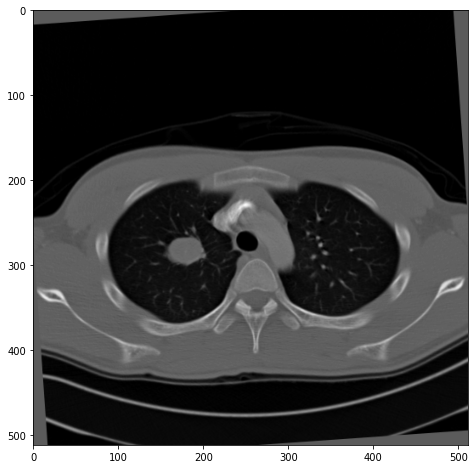

In [ ]:
img_rot = rotate(img_arr[0], np.random.randint(0,30))
plt.figure(figsize=(8,8))
plt.imshow(img_rot, cmap='gray')
plt.show()

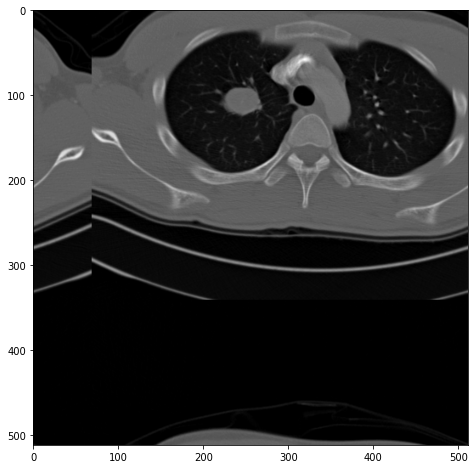

In [ ]:
img_shift = kimg.random_shift(np.array(img_arr), 0.4, 0.4, fill_mode='wrap') # nearset, reflect, wrap
plt.figure(figsize=(8,8))
plt.imshow(img_shift[0], cmap='gray')
plt.show()

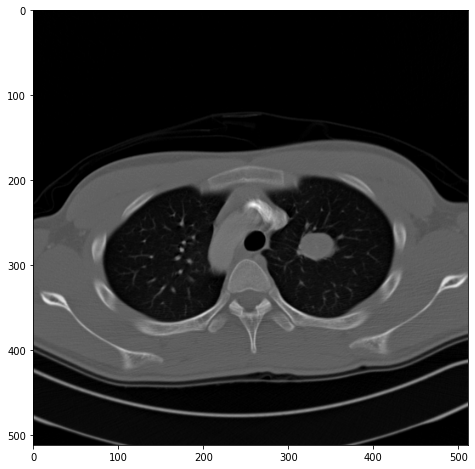

In [ ]:
img_hflip = np.fliplr(img_arr[0])
plt.figure(figsize=(8,8))
plt.imshow(img_hflip, cmap='gray')
plt.show()

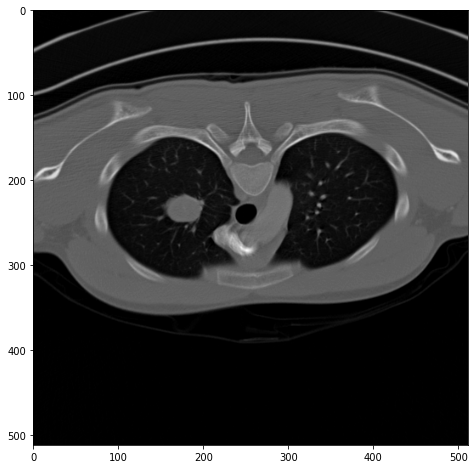

In [ ]:
img_vflip = np.flipud(img_arr[0])
plt.figure(figsize=(8,8))
plt.imshow(img_vflip, cmap='gray')
plt.show()

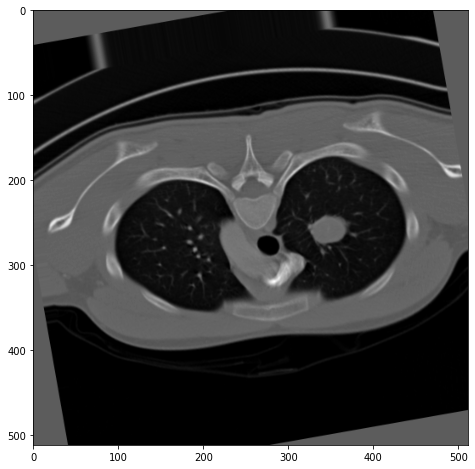

In [ ]:
img_shift1 = kimg.random_shift(img_arr, 0.1, 0.1)
img_rot1 = rotate(img_shift1[0], 10)
img_hflip1 = np.fliplr(img_rot1)
img_vflip1 = np.flipud(img_hflip1)
plt.figure(figsize=(8,8))
plt.imshow(img_vflip1, cmap='gray')
plt.show()